<a href="https://colab.research.google.com/github/kasheshjaiin/Project4_IPL/blob/Amir/IPL_Score_Prediction_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score

In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,523 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,390 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mai

In [3]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [4]:
# Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://gamesml.s3.us-west-2.amazonaws.com/ipl_history.csv"
spark.sparkContext.addFile(url)
ipl_spark_df = spark.read.csv(SparkFiles.get("ipl_history.csv"), sep=',', header= True)
ipl_spark_df.show()


+---+----------+--------------------+--------------------+--------------------+-----------+---------+----+-------+-----+-----------+--------------+-------+-----------+-----+
|mid|      date|               venue|            bat_team|           bowl_team|    batsman|   bowler|runs|wickets|overs|runs_last_5|wickets_last_5|striker|non-striker|total|
+---+----------+--------------------+--------------------+--------------------+-----------+---------+----+-------+-----+-----------+--------------+-------+-----------+-----+
|  1|2008-04-18|M Chinnaswamy Sta...|Kolkata Knight Ri...|Royal Challengers...| SC Ganguly|  P Kumar|   1|      0|  0.1|          1|             0|      0|          0|  222|
|  1|2008-04-18|M Chinnaswamy Sta...|Kolkata Knight Ri...|Royal Challengers...|BB McCullum|  P Kumar|   1|      0|  0.2|          1|             0|      0|          0|  222|
|  1|2008-04-18|M Chinnaswamy Sta...|Kolkata Knight Ri...|Royal Challengers...|BB McCullum|  P Kumar|   2|      0|  0.2|          

In [5]:
# conver spark df to pandas df
ipl = ipl_spark_df.toPandas()

# Display the first 5 rows of the dataset
ipl.head(5)


,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [6]:
# Load the IPL dataset
#ipl = pd.read_csv('ipl_history.csv')

# Display the first 5 rows of the dataset
#ipl.head(5)

In [7]:
# Dropping irrelevant columns
df = ipl.drop(['mid', 'date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'striker', 'non-striker'], axis=1)

# Display the first 5 rows of the updated DataFrame
df.head()

,venue,bat_team,bowl_team,batsman,bowler,total
0,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,222
1,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,222
2,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,222
3,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,222
4,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,222


In [8]:
# Define features (X) and target variable (y)
X = df.drop(['total'], axis=1)
y = df['total']

In [9]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object for each categorical feature
venue_encoder = LabelEncoder()
batting_team_encoder = LabelEncoder()
bowling_team_encoder = LabelEncoder()
batsman_encoder = LabelEncoder()
bowler_encoder = LabelEncoder()

# Fit and transform the categorical features with label encoding
X['venue'] = venue_encoder.fit_transform(X['venue'])
X['bat_team'] = batting_team_encoder.fit_transform(X['bat_team'])
X['bowl_team'] = bowling_team_encoder.fit_transform(X['bowl_team'])
X['batsman'] = batsman_encoder.fit_transform(X['batsman'])
X['bowler'] = bowler_encoder.fit_transform(X['bowler'])

# Display the first 5 rows of the updated DataFrame
X.head()

,venue,bat_team,bowl_team,batsman,bowler
0,14,6,12,328,201
1,14,6,12,61,201
2,14,6,12,61,201
3,14,6,12,61,201
4,14,6,12,61,201


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   venue      76014 non-null  int64
 1   bat_team   76014 non-null  int64
 2   bowl_team  76014 non-null  int64
 3   batsman    76014 non-null  int64
 4   bowler     76014 non-null  int64
dtypes: int64(5)
memory usage: 2.9 MB


In [11]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (53209, 5)
X_test shape: (22805, 5)
y_train shape: (53209,)
y_test shape: (22805,)


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the scaled training and testing sets to verify
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

print(X_train_scaled)

X_train_scaled shape: (53209, 5)
X_test_scaled shape: (22805, 5)
[[0.44117647 0.92307692 0.         0.1902439  0.36890244]
 [0.64705882 0.15384615 0.30769231 0.95853659 0.14634146]
 [0.41176471 0.92307692 1.         0.93658537 0.53353659]
 ...
 [0.02941176 0.53846154 0.         0.5195122  0.55792683]
 [0.44117647 0.         0.53846154 0.62926829 0.83841463]
 [0.41176471 0.92307692 0.         0.93658537 0.5152439 ]]


In [13]:
y_train.astype(float)

31043    205.0
1720     158.0
62369    227.0
74763    167.0
10506    116.0
         ...  
37194    140.0
6265     145.0
54886    173.0
860      208.0
15795    171.0
Name: total, Length: 53209, dtype: float64

In [46]:
# Convert type to float for y
y_train=y_train.astype(float)
y_test=y_test.astype(float)

In [15]:
type(X_train_scaled)

numpy.ndarray

In [16]:
type(y_train)

pandas.core.series.Series

In [17]:
input_dimension = X_train_scaled.shape[1]

# Define the deep learning model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=512, activation="relu", input_dim=input_dimension))
nn_model.add(tf.keras.layers.Dense(units=256, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=128, activation="relu"))

# Output layer with linear activation for regression
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the model with Huber loss
huber_loss = tf.keras.losses.Huber(delta=1.0) # You can adjust the 'delta' parameter as needed
nn_model.compile(optimizer='adam', loss=huber_loss) # Use Huber loss for regression

In [18]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
1663/1663 [==============================] - 10s 6ms/step - loss: 25.7511
Epoch 2/50
1663/1663 [==============================] - 10s 6ms/step - loss: 22.2721
Epoch 3/50
1663/1663 [==============================] - 11s 6ms/step - loss: 22.1391
Epoch 4/50
1663/1663 [==============================] - 10s 6ms/step - loss: 21.9086
Epoch 5/50
1663/1663 [==============================] - 9s 6ms/step - loss: 21.7833
Epoch 6/50
1663/1663 [==============================] - 11s 6ms/step - loss: 21.6097
Epoch 7/50
1663/1663 [==============================] - 9s 6ms/step - loss: 21.4683
Epoch 8/50
1663/1663 [==============================] - 10s 6ms/step - loss: 21.3360
Epoch 9/50
1663/1663 [==============================] - 10s 6ms/step - loss: 21.1182
Epoch 10/50
1663/1663 [==============================] - 10s 6ms/step - loss: 20.9304
Epoch 11/50
1663/1663 [==============================] - 8s 5ms/step - loss: 20.7683
Epoch 12/50
1663/1663 [==============================] - 10s 6ms/s

<Axes: >

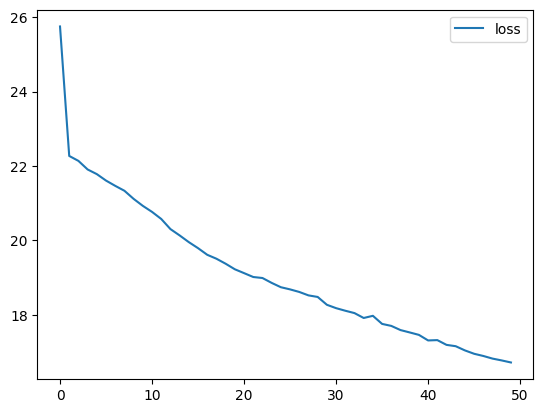

In [19]:
model_losses = pd.DataFrame(nn_model.history.history)
model_losses.plot()

In [20]:
# Make predictions
predictions = nn_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,predictions)

713/713 [==============================] - 2s 2ms/step


17.10457176538027

In [21]:
import sklearn.metrics as sm

In [22]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, predictions), 2))

Mean absolute error = 17.1
Mean squared error = 580.43


In [23]:
# Saving model
nn_model.save('ipl_predict.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Define your variables
venue = ...
batting_team = ...
bowling_team = ...
striker = ...
bowler = ...

# Store the variables
%store venue
%store batting_team
%store bowling_team
%store striker
%store bowler
%store df
%store venue_encoder
%store batting_team_encoder
%store bowling_team_encoder
%store batsman_encoder
%store bowler_encoder
%store scaler


Stored 'venue' (ellipsis)
Stored 'batting_team' (ellipsis)
Stored 'bowling_team' (ellipsis)
Stored 'striker' (ellipsis)
Stored 'bowler' (ellipsis)
Stored 'df' (DataFrame)
Stored 'venue_encoder' (LabelEncoder)
Stored 'batting_team_encoder' (LabelEncoder)
Stored 'bowling_team_encoder' (LabelEncoder)
Stored 'batsman_encoder' (LabelEncoder)
Stored 'bowler_encoder' (LabelEncoder)
Stored 'scaler' (MinMaxScaler)


# Linear Regression Model

In [25]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled,y_train)

LinearRegression()

In [26]:
# Make predictions using the X test
predictions_lin= lin_model.predict(X_test_scaled)

In [27]:
predictions_lin

array([157.72324131, 162.52651515, 160.69407495, ..., 158.70266628,
       162.04786855, 162.09079778])

In [28]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions_lin), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, predictions_lin), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, predictions_lin), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, predictions_lin), 2))
print("R2 score =", round(sm.r2_score(y_test, predictions_lin), 2))

Mean absolute error = 22.68
Mean squared error = 839.56
Median absolute error = 19.47
Explain variance score = 0.0
R2 score = 0.0


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# define dataset
# define the model
rf_model = RandomForestClassifier()
# fit the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [30]:
# Make predictions using the X test
predictions_rf = rf_model.predict(X_test_scaled)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_rf)

print(f"Accuracy Score : {acc_score}")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions_rf), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, predictions_rf), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, predictions_rf), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, predictions_rf), 2))
print("R2 score =", round(sm.r2_score(y_test, predictions_rf), 2))

Accuracy Score : 0.9486516114887086
Mean absolute error = 1.58
Mean squared error = 80.3
Median absolute error = 0.0
Explain variance score = 0.9
R2 score = 0.9


Feature:  0 , Score: 0.24594310817734436
Feature:  1 , Score: 0.1526064517940358
Feature:  2 , Score: 0.20106799048957305
Feature:  3 , Score: 0.19548380943025562
Feature:  4 , Score: 0.2048986401087912


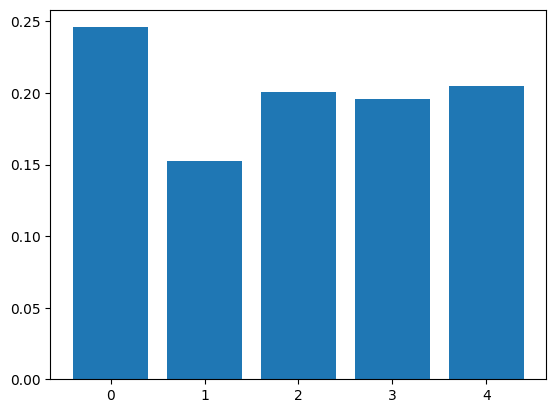

In [31]:
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ',i, ', Score:', v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Running New NN Model removing feature 1

In [37]:
X1 = X.drop(['bat_team'], axis=1)
X1.head()

,venue,bowl_team,batsman,bowler
0,14,12,328,201
1,14,12,61,201
2,14,12,61,201
3,14,12,61,201
4,14,12,61,201


In [38]:
from sklearn.model_selection import train_test_split

# Train-test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets
print("X1_train shape:", X1_train.shape)
print("X1_test shape:", X1_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X1_train shape: (53209, 4)
X1_test shape: (22805, 4)
y_train shape: (53209,)
y_test shape: (22805,)


In [39]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

# Display the shapes of the scaled training and testing sets to verify
print("X1_train_scaled shape:", X1_train_scaled.shape)
print("X1_test_scaled shape:", X1_test_scaled.shape)

print(X1_train_scaled)

X1_train_scaled shape: (53209, 4)
X1_test_scaled shape: (22805, 4)
[[0.44117647 0.         0.1902439  0.36890244]
 [0.64705882 0.30769231 0.95853659 0.14634146]
 [0.41176471 1.         0.93658537 0.53353659]
 ...
 [0.02941176 0.         0.5195122  0.55792683]
 [0.44117647 0.53846154 0.62926829 0.83841463]
 [0.41176471 0.         0.93658537 0.5152439 ]]


In [47]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 53209 entries, 31043 to 15795
Series name: total
Non-Null Count  Dtype  
--------------  -----  
53209 non-null  float64
dtypes: float64(1)
memory usage: 831.4 KB


In [44]:
type(X1_train_scaled)

numpy.ndarray

In [41]:
input_dimension = X1_train_scaled.shape[1]

# Define the deep learning model
nn_model_1 = tf.keras.models.Sequential()
nn_model_1.add(tf.keras.layers.Dense(units=512, activation="relu", input_dim=input_dimension))
nn_model_1.add(tf.keras.layers.Dense(units=256, activation="relu"))
nn_model_1.add(tf.keras.layers.Dense(units=128, activation="relu"))

# Output layer with linear activation for regression
nn_model_1.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the model with Huber loss
huber_loss_1 = tf.keras.losses.Huber(delta=1.0) # You can adjust the 'delta' parameter as needed
nn_model_1.compile(optimizer='adam', loss=huber_loss_1) # Use Huber loss for regression

In [55]:
# Train the model
fit_model_1 = nn_model_1.fit(X1_train_scaled, y_train, epochs=50)

Epoch 1/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.6190
Epoch 2/50
1663/1663 [==============================] - 9s 5ms/step - loss: 19.5653
Epoch 3/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.4747
Epoch 4/50
1663/1663 [==============================] - 9s 5ms/step - loss: 19.4279
Epoch 5/50
1663/1663 [==============================] - 9s 5ms/step - loss: 19.3911
Epoch 6/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.3050
Epoch 7/50
1663/1663 [==============================] - 8s 5ms/step - loss: 19.2478
Epoch 8/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.2268
Epoch 9/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.1216
Epoch 10/50
1663/1663 [==============================] - 8s 5ms/step - loss: 19.0577
Epoch 11/50
1663/1663 [==============================] - 10s 6ms/step - loss: 19.0375
Epoch 12/50
1663/1663 [==============================] - 10s 6ms/ste

<Axes: >

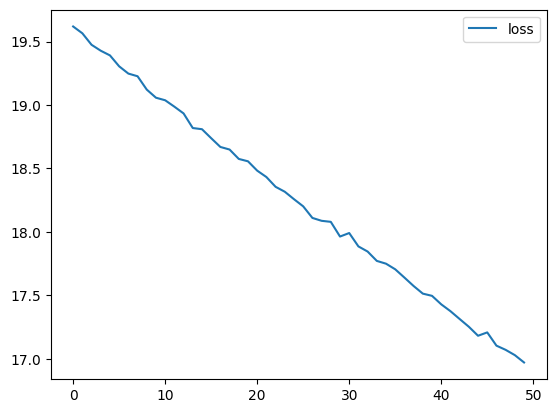

In [56]:
model_losses_1 = pd.DataFrame(nn_model_1.history.history)
model_losses_1.plot()

In [57]:
# Make predictions
predictions_X1 = nn_model_1.predict(X1_test_scaled)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,predictions_X1)

713/713 [==============================] - 1s 2ms/step


17.98139224730937

In [58]:
import sklearn.metrics as sm

In [60]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions_X1), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, predictions_X1), 2))

Mean absolute error = 17.98
Mean squared error = 629.04


In [61]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, predictions), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, predictions), 2))

Mean absolute error = 17.1
Mean squared error = 580.43


In [62]:
# Saving model
nn_model_1.save('ipl_predict_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
